In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Glaucoma_Detection/Dataset_Preparation')

In [2]:
def point_check(pt):
  newpt = [0,0]
  newpt[0] = 0 if pt[0] < 0 else pt[0]
  newpt[1] = 0 if pt[1] < 0 else pt[1]
  return tuple(newpt)

def patch_extraction(img_path):
  output_dim = 512
  # img_path = "/content/drive/MyDrive/GUI/Predictions/IDRiD_12/IDRiD_12.jpg"
  image = Image.open(img_path)
  im_w, im_h = image.size
  var = round(0.15 * im_w)
  starting_threshold = 250

  while True:
    # load the image, convert it to grayscale, and blur it
    image = cv2.imread(img_path)
    # image[:, 2144:, :] = 0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray,9,75,75)
    median=cv2.medianBlur(gray,5)
    # cv2_imshow(median)

    # threshold the image to reveal light regions in the blurred image
    thresh = cv2.threshold(median, starting_threshold, 255, cv2.THRESH_BINARY)[1]

    # perform a series of erosions and dilations to remove any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    # perform a connected component analysis on the thresholded image, then initialize a mask to store only the "large" components
    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # print(np.unique(labels))

    largest_blob = 0
    # loop over the unique components
    for label in np.unique(labels):
      # if this is the background label, ignore it
      if label == 0:
        continue
      # print("Creating mask")
      # otherwise, construct the label mask and count the number of pixels
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)
      # if the number of pixels in the component is sufficiently large, then add it to our mask of "large blobs"
      if numPixels > largest_blob:
        largest_blob = numPixels
        mask = labelMask

    # find the contours in the mask, then sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    #If there is nothing found for the image
    if cnts == []:
      starting_threshold -= 10
      # print("Decreasing threshold by 10. Now:", starting_threshold)
      continue

    cnts = contours.sort_contours(cnts)[0]

    for (i, c) in enumerate(cnts):
      (x, y, w, h) = cv2.boundingRect(c)

      center = (round(x+(w/2)), round(y+(h/2)))
      cv2.putText(image, "O", center, cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      box_radius = output_dim//2

      # Dristi Dataset
      # tl_pt = [center[0]-box_radius-50, center[1]-box_radius-100]
      # br_pt = [center[0]+box_radius, center[1]+box_radius]

      # IDRiD Dataset
      tl_pt = [center[0]-box_radius-250, center[1]-box_radius-300]
      br_pt = [center[0]+box_radius+250, center[1]+box_radius+300]

      #Check if TL point is out of bounds
      if tl_pt[0] < 0:
        neg = tl_pt[0] * -1
        tl_pt[0] = 0
        br_pt[0] += neg

      if tl_pt[1] < 0:
        neg = tl_pt[1] * -1
        tl_pt[1] = 0
        br_pt[1] += neg

      #Check if BR point is out of bounds
      if br_pt[0] > im_w:
        pos = im_w-br_pt[0]
        br_pt[0] = im_w
        tl_pt[0] -= pos

      if br_pt[1] > im_h:
        pos = im_h-br_pt[1]
        br_pt[1] = im_h
        tl_pt[1] -= pos

      cv2.rectangle(image,tuple(tl_pt) , tuple(br_pt), (255,0,0), 3)
      break
    # print("Wid: ", br_pt[0]-tl_pt[0], "\tHei:", br_pt[1]-tl_pt[1])
    # image=cv2.resize(image,(512,512))
    image=cv2.resize(image,(im_w, im_h))
    # cv2_imshow(image)
    return tl_pt, br_pt
    break



In [3]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import cv2
from imutils import contours
from skimage import measure
import imutils
# from google.colab.patches import cv2_imshow

# Train Patch Extraction
# root_path_training = "/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Training"
# save_path = "/content/drive/MyDrive/Glaucoma_Detection/Optic_Disk_patches/Training"
# images_path = os.path.join(root_path_training, sorted(os.listdir(root_path_training))[0])
# masks_path = os.path.join(root_path_training, sorted(os.listdir(root_path_training))[1])

# Test Patch Extraction (Not needed actually)
root_path_testing = "/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Testing"
save_path = "/content/drive/MyDrive/Glaucoma_Detection/Optic_Disk_patches/Testing"
images_path = os.path.join(root_path_testing, sorted(os.listdir(root_path_testing))[0])
masks_path = os.path.join(root_path_testing, sorted(os.listdir(root_path_testing))[1])

images_path, masks_path

('/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Testing/Images',
 '/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Testing/Optic_Disk_GTs')

In [4]:
# img - (4288, 2848)
# img_array - (2848, 4288, 3)

save_img_patch_path = os.path.join(save_path, "Image_Patches")
save_mask_patch_path = os.path.join(save_path, "Optic_Disc_GT_Patches")

for i in tqdm(range(len(os.listdir(images_path)))):
  assert (len(sorted(os.listdir(images_path))) == len(sorted(os.listdir(masks_path))))

  # Extract Image and it's corresponding segmentation patches
  img_path = os.path.join(images_path, sorted(os.listdir(images_path))[i])
  mask_path = os.path.join(masks_path, sorted(os.listdir(masks_path))[i])
  image, mask = np.asarray(Image.open(img_path)), np.asarray(Image.open(mask_path))
  # print(img_path) # ((2848, 4288, 3) - (0, 255)
  # print(mask_path) # (2848, 4288)) - (0, 1)
  tl_pt, br_pt = patch_extraction(img_path)
  img_patch = image[tl_pt[1]:br_pt[1], tl_pt[0]:br_pt[0], :]
  mask_patch = mask[tl_pt[1]:br_pt[1], tl_pt[0]:br_pt[0]]

  # Make directories
  if not os.path.exists(save_img_patch_path):
    os.mkdir(save_img_patch_path)
  if not os.path.exists(save_mask_patch_path):
    os.mkdir(save_mask_patch_path)

  # Save the Image and it's corresponding segmentation patches
  img_temp = Image.fromarray(img_patch)
  img_temp.save(os.path.join(save_img_patch_path, img_path.split('/')[-1]))

  mask_temp = (255. * mask_patch).astype(np.uint8)
  mask_temp = Image.fromarray(mask_temp)
  mask_temp.save(os.path.join(save_mask_patch_path, mask_path.split('/')[-1].split('.')[0] + ".jpg"))


100%|██████████| 27/27 [03:37<00:00,  8.06s/it]


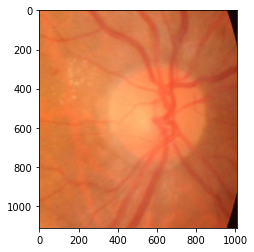

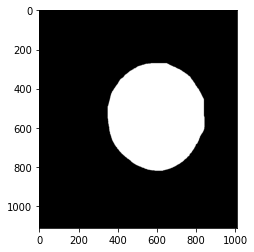

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_patch)
plt.show()
plt.imshow(mask_patch, cmap="gray")
plt.show()